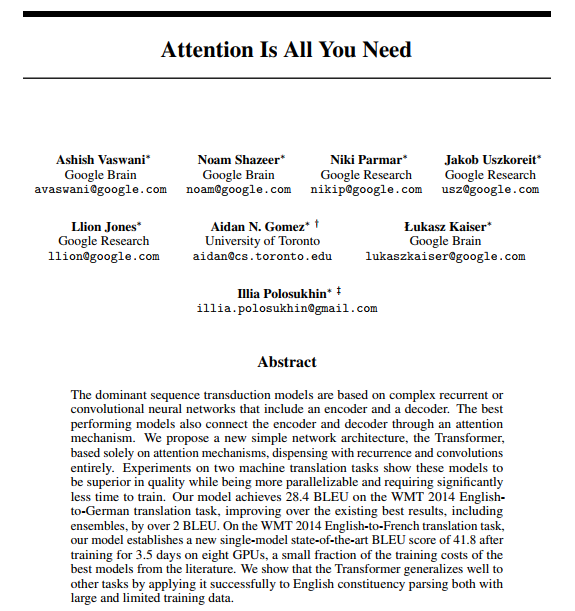


> When teaching, I emphasize implementation as a way to understand recent developments in ML. This post is an attempt to keep myself honest along this goal. The recent ["Attention is All You Need"]
(https://arxiv.org/abs/1706.03762) paper from NIPS 2017 has been instantly impactful paper as a new method for machine translation and potentiall NLP generally. The paper is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly.
>
> In this post I follow the paper through from start to finish and try to implement each component in code.
(I have done some minor reordering and skipping from the original paper). This document itself is a working notebook, and should be a completely usable and efficient implementation. To follow along you will first need to install [PyTorch](http://pytorch.org/) and [torchtext](https://github.com/pytorch/text). The complete code is available on [github](https://github.com/harvardnlp/annotated-transformer).
>- Alexander "Sasha" Rush ([@harvardnlp](https://twitter.com/harvardnlp))


Ligas de referencia:

*   https://nlp.seas.harvard.edu/2018/04/03/attention.html
*   http://jalammar.github.io/illustrated-transformer/



In [ ]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext

ERROR: torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.


In [ ]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt
import time

* Table of Contents                               
{:toc}      

# Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU
[16], ByteNet [18] and ConvS2S [9], all of which use convolutional neural networks as basic building
block, computing hidden representations in parallel for all input and output positions. In these models,
the number of operations required to relate signals from two arbitrary input or output positions grows
in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes
it more difficult to learn dependencies between distant positions [12]. In the Transformer this is
reduced to a constant number of operations, albeit at the cost of reduced effective resolution due
to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention as
described in section 3.2.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions
of a single sequence in order to compute a representation of the sequence. Self-attention has been
used successfully in a variety of tasks including reading comprehension, abstractive summarization,
textual entailment and learning task-independent sentence representations [4, 27, 28, 22].
End-to-end memory networks are based on a recurrent attention mechanism instead of sequencealigned
recurrence and have been shown to perform well on simple-language question answering and
language modeling tasks [34].

To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequencealigned
RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].

# Model Architecture

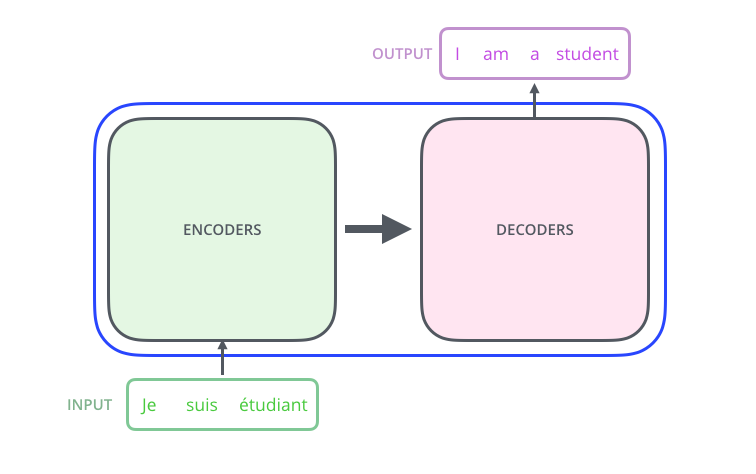

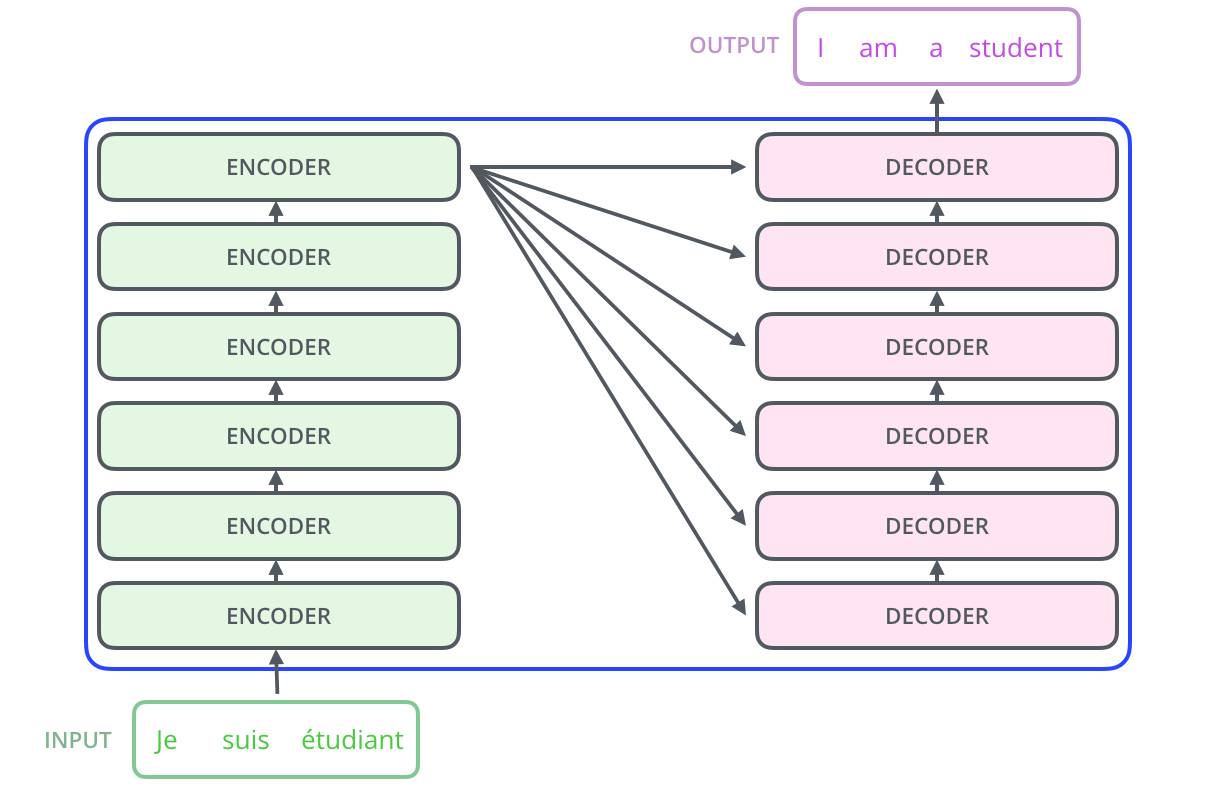

Most competitive neural sequence transduction models have an encoder-decoder structure [(cite)](cho2014learning,bahdanau2014neural,sutskever14). Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive [(cite)](graves2013generating), consuming the previously generated symbols as additional input when generating the next.

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

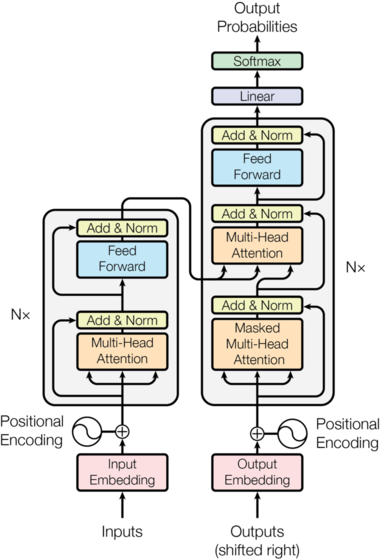

## Encoder and Decoder Stacks   

### Encoder:

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection [(cite)](he2016deep) around each of the two sub-layers, followed by layer normalization [(cite)](layernorm2016).  

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout [(cite)](srivastava2014dropout) to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.  

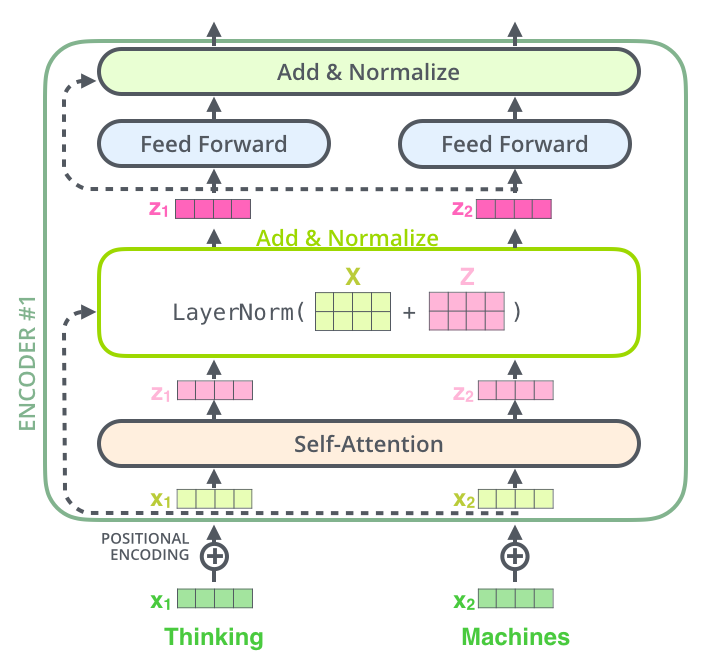

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return self.norm(x + self.dropout(sublayer(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder:

The decoder is also composed of a stack of $N=6$ identical layers.  


In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack.  Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.  

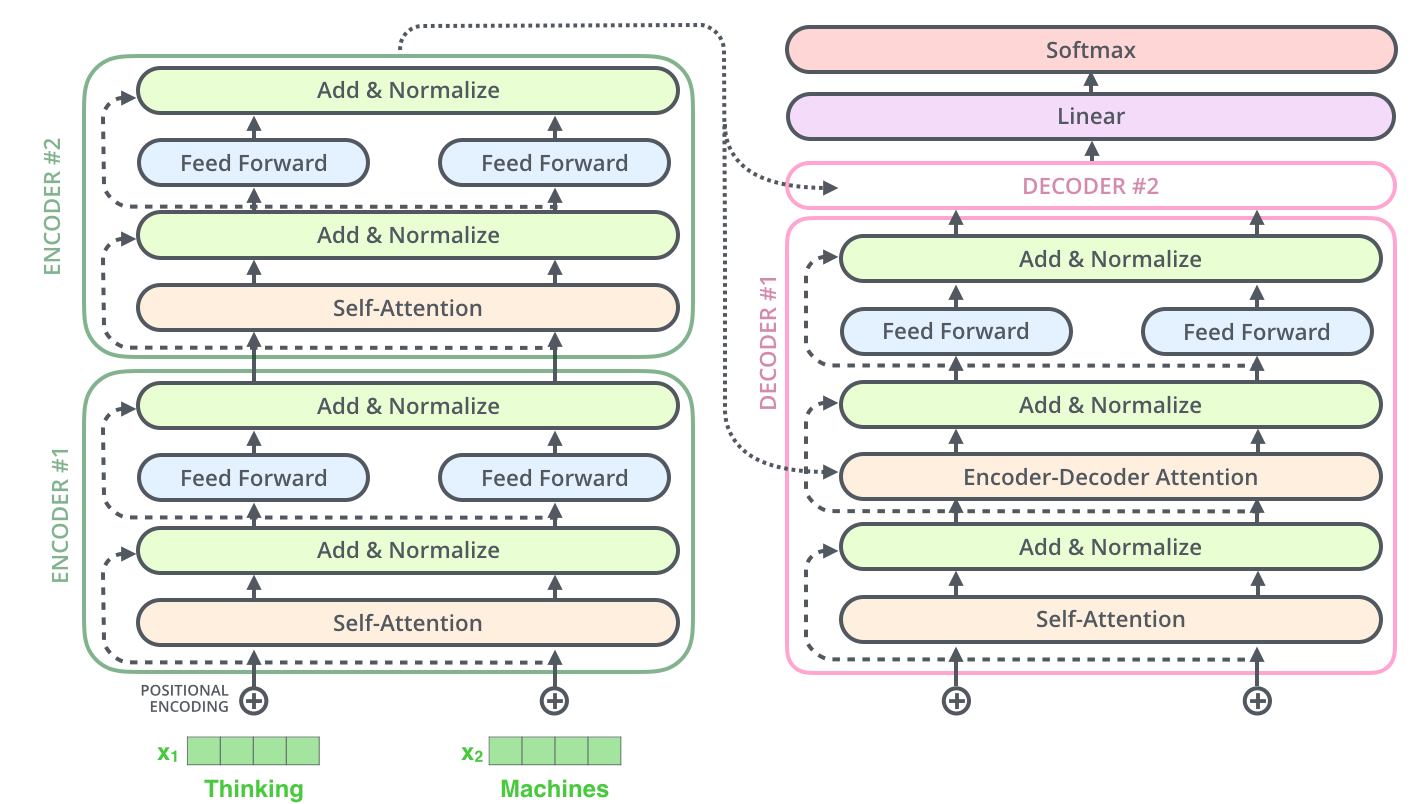

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

### Attention mechanism

### Attention:                                                                                                                                                                                                                                                                               
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                                                                           

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.                                                                         

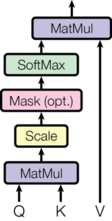

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$                                                                                                                                                                                                        
                                                                                                                                                                     

In [ ]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

[ True False False False False False False False False False False False
 False False False False False False False False]
[ True  True False False False False False False False False False False
 False False False False False False False False]


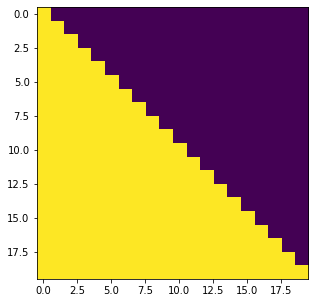

In [ ]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training.
plt.figure(figsize=(5,5))
mask = subsequent_mask(20)
plt.imshow(mask[0])
print(mask[0][0].numpy())
print(mask[0][1].numpy())

The two most commonly used attention functions are additive attention [(cite)](bahdanau2014neural), and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

                                                                        
While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [(cite)](DBLP:journals/corr/BritzGLL17). We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

### Multi-Head Attention                                                                                                                                                                                                                                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively.                                                                                                                                                                                                   
On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values:


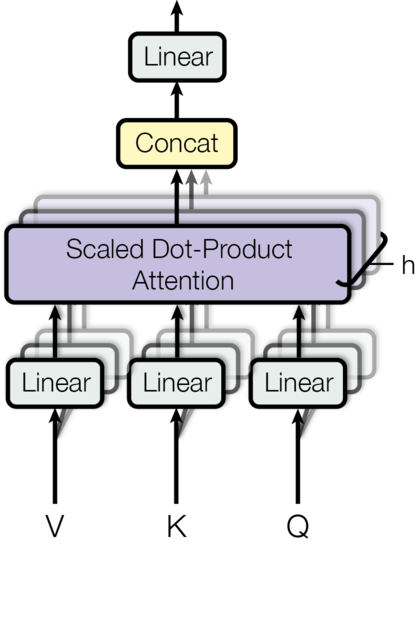                                                                                                                                                                                                                            
Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                                                                                                                                                                                                                                                                             
    
    
   
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                                                                                        
   

   
In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.   

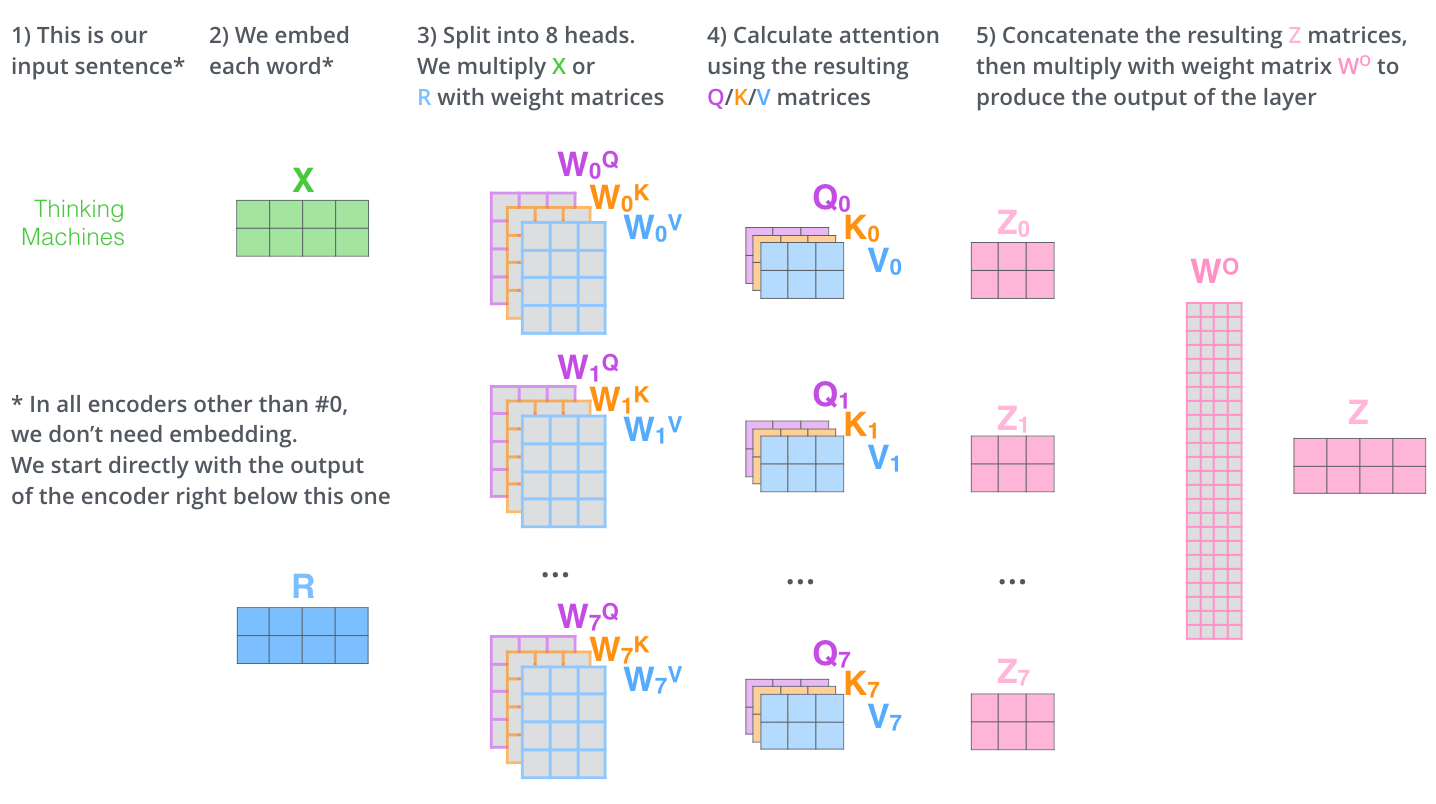

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Applications of Attention in our Model                                                                                                                                                      
The Transformer uses multi-head attention in three different ways:                                                        
1) In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.   This allows every position in the decoder to attend over all positions in the input sequence.  This mimics the typical encoder-decoder attention mechanisms in sequence-to-sequence models such as [(cite)](wu2016google, bahdanau2014neural,JonasFaceNet2017).    


2) The encoder contains self-attention layers.  In a self-attention layer all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder.   Each position in the encoder can attend to all positions in the previous layer of the encoder.                                                   


3) Similarly, self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position.  We need to prevent leftward information flow in the decoder to preserve the auto-regressive property.  We implement this inside of scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the softmax which correspond to illegal connections.                                                                                                                                                                                                                                                      

## Position-wise Feed-Forward Networks                                                                                                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default.
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax                                                                                                                                                                                                                                                                                           
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation, similar to [(cite)](press2016using). In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.                                                                                                                                 

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding                                                                                                                             
Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed [(cite)](JonasFaceNet2017).

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                                                                                                                                                                                                                                                                                                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                                                                                                                                                                                                                                                                                                                                                                                                                                       
$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$.
                                                                                                                                                                                                                                                    


In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

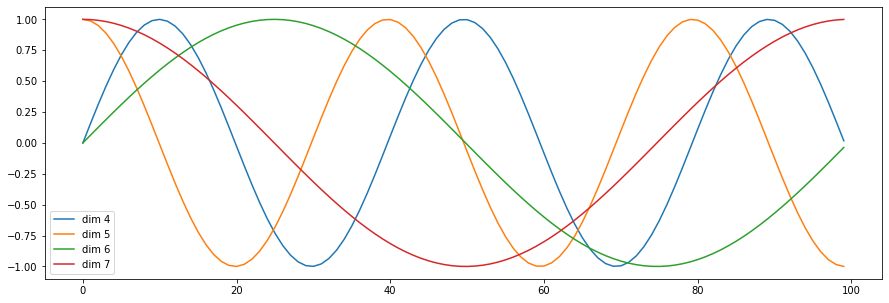

In [ ]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

We also experimented with using learned positional embeddings [(cite)](JonasFaceNet2017) instead, and found that the two versions produced nearly identical results.  We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.    

## Full Model

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))

    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

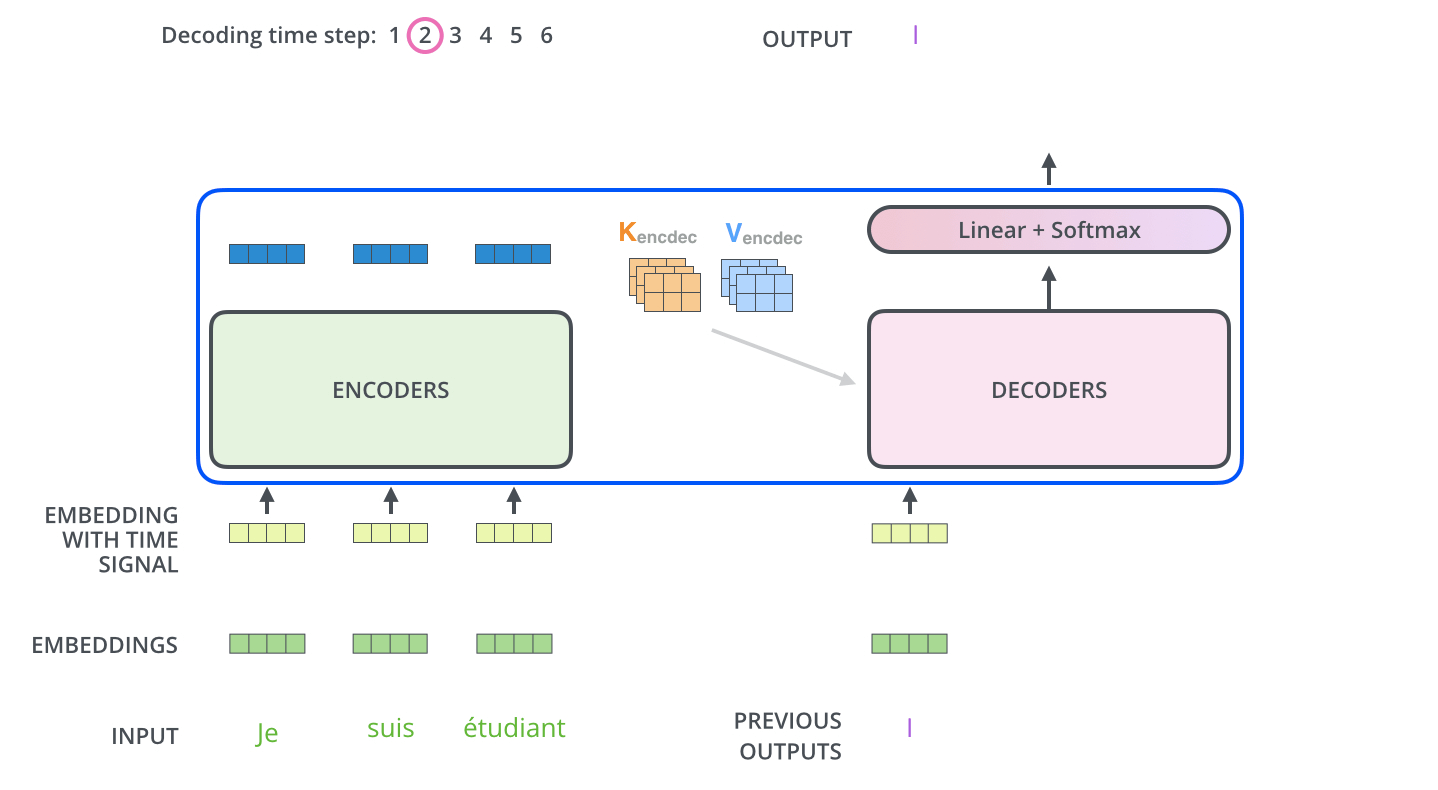

In [ ]:
# Small example model.
tmp_model = make_model(src_vocab=10, tgt_vocab=10, N=3)
tmp_model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=Fals

# BERT Training
### Classifying movie genres from plot and movie poster

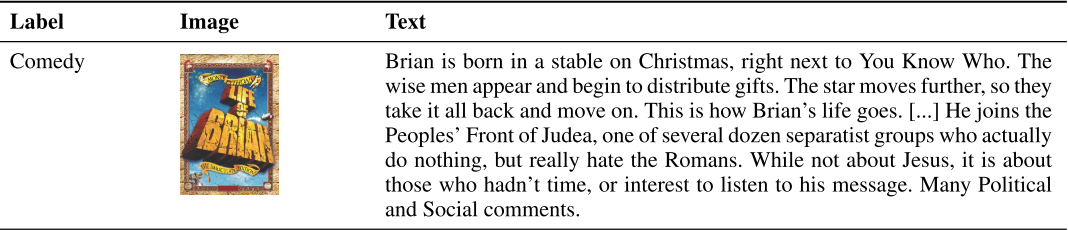

Gated Multimodal Units for Information Fusion (Arevalo et al.)

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 14.1 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 596 kB 70.6 MB/s 
     |████████████████████████████████| 6.6 MB 59.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import json
import numpy as np
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import functools
from collections import Counter
from argparse import Namespace
from transformers import BertTokenizer, BertModel
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
!wget https://archive.org/download/mmimdb/mmimdb.tar.gz

--2022-05-14 05:00:33--  https://archive.org/download/mmimdb/mmimdb.tar.gz
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia803005.us.archive.org/6/items/mmimdb/mmimdb.tar.gz [following]
--2022-05-14 05:00:33--  https://ia803005.us.archive.org/6/items/mmimdb/mmimdb.tar.gz
Resolving ia803005.us.archive.org (ia803005.us.archive.org)... 207.241.233.25
Connecting to ia803005.us.archive.org (ia803005.us.archive.org)|207.241.233.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8693248518 (8.1G) [application/octet-stream]
Saving to: ‘mmimdb.tar.gz’

mmimdb.tar.gz         1%[                    ] 159.87M   245KB/s    eta 10h 47m^C


In [ ]:
!tar -zxf mmimdb.tar.gz

Vocabulary

In [ ]:
class Vocab(object):
    def __init__(self, emptyInit=False):
        if emptyInit:
            self.stoi, self.itos, self.vocab_sz = {}, [], 0
        else:
            self.stoi = {
                w: i
                for i, w in enumerate(["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
            }
            self.itos = [w for w in self.stoi]
            self.vocab_sz = len(self.itos)

    def add(self, words):
        cnt = len(self.itos)
        for w in words:
            if w in self.stoi:
                continue
            self.stoi[w] = cnt
            self.itos.append(w)
            cnt += 1
        self.vocab_sz = len(self.itos)

In [ ]:
args = Namespace()
args.savedir = os.path.join('model_save', 'concat_bert')
os.makedirs(args.savedir, exist_ok=True)
args.data_path = "mmimdb"

Load dataset partitions, set of labels (Movie genres) and frequencies


In [ ]:
label_freqs = Counter()
data_labels = [json.loads(line)["label"] for line in open(os.path.join(args.data_path, "train.jsonl"))]

if type(data_labels[0]) == list:
    for label_row in data_labels:
        label_freqs.update(label_row)
else:
    label_freqs.update(data_labels)

args.labels = list(label_freqs.keys())
args.label_freqs = label_freqs

In [ ]:
args.labels

['Drama',
 'Film-Noir',
 'Mystery',
 'Thriller',
 'Adventure',
 'Crime',
 'Horror',
 'Romance',
 'Sport',
 'Fantasy',
 'Biography',
 'Action',
 'Music',
 'War',
 'Documentary',
 'Short',
 'Animation',
 'Comedy',
 'Family',
 'Musical',
 'Sci-Fi',
 'Western',
 'History']

Create vocabulary

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
vocab = Vocab()
vocab.stoi = tokenizer.vocab
vocab.itos = tokenizer.ids_to_tokens
vocab.vocab_sz = len(vocab.itos)
args.vocab = vocab
args.vocab_sz = vocab.vocab_sz
args.n_classes = len(args.labels)
tokenizer = tokenizer.tokenize

In [ ]:
args.n_classes

23

Dataset

In [ ]:
class JsonlDataset(Dataset):
    def __init__(self, data_path, tokenizer, transforms, vocab, args):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = tokenizer
        self.args = args
        self.vocab = vocab
        self.n_classes = len(args.labels)
        self.text_start_token = ["[CLS]"]

        self.max_seq_len = args.max_seq_len
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = (
            self.text_start_token
            + self.tokenizer(self.data[index]["text"])[:(self.args.max_seq_len - 1)]
        )
        segment = torch.zeros(len(sentence))

        sentence = torch.LongTensor(
            [
                self.vocab.stoi[w] if w in self.vocab.stoi else self.vocab.stoi["[UNK]"]
                for w in sentence
            ]
        )

        label = torch.zeros(self.n_classes)
        label[
            [self.args.labels.index(tgt) for tgt in self.data[index]["label"]]
        ] = 1

        if self.data[index]["img"]:
            image = Image.open(
                os.path.join(self.data_dir, self.data[index]["img"])
            ).convert("RGB")

        image = self.transforms(image)

        return sentence, segment, image, label

Collate function to process batch

In [ ]:
def collate_fn(batch, args):
    lens = [len(row[0]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len).long()
    text_tensor = torch.zeros(bsz, max_seq_len).long()
    segment_tensor = torch.zeros(bsz, max_seq_len).long()

    img_tensor = torch.stack([row[2] for row in batch])

    tgt_tensor = torch.stack([row[3] for row in batch])

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        tokens, segment = input_row[:2]
        text_tensor[i_batch, :length] = tokens
        segment_tensor[i_batch, :length] = segment
        mask_tensor[i_batch, :length] = 1

    return text_tensor, segment_tensor, mask_tensor, img_tensor, tgt_tensor

Configure Dataset parameters

In [ ]:
args.max_seq_len = 512
args.batch_sz = 4
args.n_workers = 12

Create DataLoaders

In [ ]:
model_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.46777044, 0.44531429, 0.40661017],
            std=[0.12221994, 0.12145835, 0.14380469],
        ),
    ]
)

train = JsonlDataset(
    os.path.join(args.data_path, "train.jsonl"),
    tokenizer,
    model_transforms,
    vocab,
    args,
)

args.train_data_len = len(train)

dev = JsonlDataset(
    os.path.join(args.data_path, "dev.jsonl"),
    tokenizer,
    model_transforms,
    vocab,
    args,
)

collate = functools.partial(collate_fn, args=args)

train_loader = DataLoader(
    train,
    batch_size=args.batch_sz,
    shuffle=True,
    num_workers=args.n_workers,
    collate_fn=collate,
    drop_last=True,
)

val_loader = DataLoader(
    dev,
    batch_size=args.batch_sz,
    shuffle=False,
    num_workers=args.n_workers,
    collate_fn=collate,
)

test_set = JsonlDataset(
    os.path.join(args.data_path, "test.jsonl"),
    tokenizer,
    model_transforms,
    vocab,
    args,
)

test_loader = DataLoader(
    test_set,
    batch_size=args.batch_sz,
    shuffle=False,
    num_workers=args.n_workers,
    collate_fn=collate,
)

Define model

In [ ]:
class BertEncoder(nn.Module):
    def __init__(self, args):
        super(BertEncoder, self).__init__()
        self.args = args
        self.bert = BertModel.from_pretrained("bert-base-uncased")

    def forward(self, txt, mask, segment):
        _, out = self.bert(
            txt,
            token_type_ids=segment,
            attention_mask=mask,
            output_hidden_states=False,
        )
        return out

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, args):
        super(ImageEncoder, self).__init__()
        self.args = args
        model = torchvision.models.resnet152(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)

        pool_func = (
            nn.AdaptiveAvgPool2d
            if args.img_embed_pool_type == "avg"
            else nn.AdaptiveMaxPool2d
        )

        if args.num_image_embeds in [1, 2, 3, 5, 7]:
            self.pool = pool_func((args.num_image_embeds, 1))
        elif args.num_image_embeds == 4:
            self.pool = pool_func((2, 2))
        elif args.num_image_embeds == 6:
            self.pool = pool_func((3, 2))
        elif args.num_image_embeds == 8:
            self.pool = pool_func((4, 2))
        elif args.num_image_embeds == 9:
            self.pool = pool_func((3, 3))

    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out  # BxNx2048

In [ ]:
class MultimodalConcatBertClf(nn.Module):
    def __init__(self, args):
        super(MultimodalConcatBertClf, self).__init__()
        self.args = args
        self.txtenc = BertEncoder(args)
        self.imgenc = ImageEncoder(args)

        last_size = args.hidden_sz + (args.img_hidden_sz * args.num_image_embeds)
        self.clf = nn.ModuleList()

        self.clf.append(nn.Linear(last_size, args.n_classes))

    def forward(self, txt, mask, segment, img):
        txt = self.txtenc(txt, mask, segment)
        img = self.imgenc(img)
        img = torch.flatten(img, start_dim=1)
        out = torch.cat([txt, img], -1)
        for layer in self.clf:
            out = layer(out)
        return out

Define model hyperparameters and instantiate

In [ ]:
args.img_embed_pool_type = "avg"
args.num_image_embeds = 1
args.hidden_sz = 768
args.img_hidden_sz = 2048

In [ ]:
model = MultimodalConcatBertClf(args)

Create loss criterion

In [ ]:
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())

Create optimizer

In [ ]:
args.lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=args.lr)

Create scheduler

In [ ]:
args.lr_patience = 2
args.lr_factor = 0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

Setup training

In [ ]:
model.cuda();
torch.save(args, os.path.join(args.savedir, "args.pt"))
start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

args.max_epochs = 100
args.gradient_accumulation_steps = 16
args.patience = 10

Model evaluation function

In [ ]:
def model_eval(i_epoch, data, model, args, criterion):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        for batch in data:
            txt, segment, mask, img, tgt = batch

            txt, img = txt.cuda(), img.cuda()
            mask, segment = mask.cuda(), segment.cuda()
            tgt = tgt.cuda()

            out = model(txt, mask, segment, img)
            loss = criterion(out, tgt)
            losses.append(loss.item())

            pred = nn.functional.softmax(out, dim=1).argmax(dim=1).cpu().detach().numpy()

            preds.append(pred)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    metrics = {"loss": np.mean(losses)}

    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    metrics["macro_f1"] = f1_score(tgts, preds, average="macro")
    metrics["micro_f1"] = f1_score(tgts, preds, average="micro")

    return metrics

Function for saving model

In [ ]:
import shutil

def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

Start training

In [ ]:
from sklearn.metrics import f1_score

for i_epoch in range(start_epoch, args.max_epochs):
    train_losses = []
    model.train()
    optimizer.zero_grad()

    for batch in tqdm(train_loader, total=len(train_loader)):
        txt, segment, mask, img, tgt = batch

        txt, img = txt.cuda(), img.cuda()
        mask, segment = mask.cuda(), segment.cuda()
        tgt = tgt.cuda()

        out = model(txt, mask, segment, img)
        loss = criterion(out, tgt)

        if args.gradient_accumulation_steps > 1:
            loss = loss / args.gradient_accumulation_steps

        train_losses.append(loss.item())
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    model.eval()
    metrics = model_eval(i_epoch, val_loader, model, args, criterion)
    print("Train Loss: {:.4f}".format(np.mean(train_losses)))
    print(
            "{}: Loss: {:.5f} | Macro F1 {:.5f} | Micro F1: {:.5f}".format(
                "Val", metrics["loss"], metrics["macro_f1"], metrics["micro_f1"]
            )
        )

    tuning_metric = metrics["micro_f1"]
    scheduler.step(tuning_metric)
    is_improvement = tuning_metric > best_metric
    if is_improvement:
        best_metric = tuning_metric
        n_no_improve = 0
    else:
        n_no_improve += 1

    save_checkpoint(
        {
            "epoch": i_epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "n_no_improve": n_no_improve,
            "best_metric": best_metric,
        },
        is_improvement,
        args.savedir,
    )

    if n_no_improve >= args.patience:
        print("No improvement. Breaking out of loop.")
        break

load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
model.eval()
for test_name, test_loader in test_loaders.items():
    test_metrics = model_eval(np.inf, test_loader, model, args, criterion)
    print(
        "{}: Loss: {:.5f} | Macro F1 {:.5f} | Micro F1: {:.5f}".format(
            "Test", test_metrics["loss"], test_metrics["macro_f1"], test_metrics["micro_f1"]
        )
    )


Train Loss: 0.0701
Val: Loss: 0.91412 | Macro F1 0.33986 | Micro F1: 0.41086



Train Loss: 0.0527
Val: Loss: 0.77180 | Macro F1 0.40233 | Micro F1: 0.46999



Train Loss: 0.0449
Val: Loss: 0.70466 | Macro F1 0.44798 | Micro F1: 0.51203



Train Loss: 0.0393
Val: Loss: 0.66846 | Macro F1 0.45988 | Micro F1: 0.52479



Train Loss: 0.0351
Val: Loss: 0.66805 | Macro F1 0.48131 | Micro F1: 0.54456



Train Loss: 0.0314
Val: Loss: 0.66050 | Macro F1 0.51008 | Micro F1: 0.56918



Train Loss: 0.0284
Val: Loss: 0.66818 | Macro F1 0.51322 | Micro F1: 0.56937



Train Loss: 0.0258
Val: Loss: 0.67284 | Macro F1 0.52550 | Micro F1: 0.58449



Train Loss: 0.0235
Val: Loss: 0.69362 | Macro F1 0.54417 | Micro F1: 0.60117



Train Loss: 0.0216
Val: Loss: 0.73900 | Macro F1 0.56594 | Micro F1: 0.61812



Train Loss: 0.0198
Val: Loss: 0.78064 | Macro F1 0.57418 | Micro F1: 0.62076



Train Loss: 0.0182
Val: Loss: 0.77951 | Macro F1 0.57251 | Micro F1: 0.62529



Train Loss: 0.0168
Val: Loss: 0.81005 | Macro F1 0.58165 | Micro F1: 0.63475



Train Loss: 0.0154
Val: Loss: 0.87564 | Macro F1 0.59267 | Micro F1: 0.64327



Train Loss: 0.0143
Val: Loss: 0.90381 | Macro F1 0.59325 | Micro F1: 0.64072



Train Loss: 0.0131
Val: Loss: 0.95709 | Macro F1 0.59608 | Micro F1: 0.64868



Train Loss: 0.0123
Val: Loss: 0.96745 | Macro F1 0.59791 | Micro F1: 0.65165



Train Loss: 0.0112
Val: Loss: 1.01757 | Macro F1 0.60418 | Micro F1: 0.65570



Train Loss: 0.0104
Val: Loss: 0.95129 | Macro F1 0.59368 | Micro F1: 0.64486



Train Loss: 0.0096
Val: Loss: 1.08837 | Macro F1 0.59713 | Micro F1: 0.64781



Train Loss: 0.0089
Val: Loss: 1.07693 | Macro F1 0.59550 | Micro F1: 0.64572
Epoch    21: reducing learning rate of group 0 to 5.0000e-06.



Train Loss: 0.0082
Val: Loss: 1.09595 | Macro F1 0.60103 | Micro F1: 0.65517


Original results:

Macro F1: 0.549

Micro F1: 0.636